In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
%matplotlib inline
#np.set_printoptions(threshold=np.nan)

In [2]:
# crete_random_data(N=number of parties,M=number of communes)
# for each commune, create a random percentage distribution for the list of parties

def create_random_data(N,M):
    ptab = 2 * np.random.rand(N)
    tab = ptab[:,np.newaxis] + np.random.normal(0.0,0.5,(N,M))
    #tab = 1 * np.random.rand(N, M)
    tab = np.exp(tab)
    stab = np.sum(tab, 0)
    tab = tab / stab[None, :]
    return tab

#create_random_pop(M=number of communes)
#for each commune create a random population

def create_random_pop(M):
    #pop = np.random.randint(1000,size=M)
    pop = np.floor((np.random.pareto(1, size=M))*500)
    return pop

#vote(data=table with the percentage of each party for each canton,Nrepr=number of represent to elec for each canton)
#compute the vote to get the number of representants per cantons (check the highest percentage give it a representant,
#substract 1/Nrepr and repeat).

def vote(data,Nrepr):
    repr=np.zeros(data.shape)
    for i in range(Nrepr):
        maxi=np.argmax(data,0)

        k = (maxi[:,None]==np.arange(data.shape[0])).transpose()
        repr = repr + k.astype(int)
        data[k]=data[k]-(1/Nrepr)

    nan_tab = np.isnan(data)
    repr[nan_tab]=0

    return repr

#compute_tab_K(tab=percentage of vote by parties and commune,pop=population of each commune,K_index=canton of each commune)
#aggregate the vote per cantons

def compute_tab_K(tab,pop,K_index,K):
    K_full = (K_index[:, None] == np.arange(K))
    tab_mult_by_pop = pop * tab
    tab_sum = np.matmul(tab_mult_by_pop, K_full.astype(float))
    K_sum = (pop * K_full.transpose()).sum(1)

    final_tab = tab_sum/K_sum
    #nan_tab = np.isnan(final_tab)
    #final_tab[nan_tab]=0

    return final_tab

#reproduce(K_index1=canton for each commune (one repartition),K_index1=canton for each commune (another repartition))
#create a new repartition given two (select randomly one element in each repartition)

def reproduce_K(K_index1,K_index2):
    choice=np.random.randint(2,size=K_index1.shape)
    K_tot=np.stack([K_index1,K_index2],axis=1)
    return(K_tot[choice[:,None]==np.arange(2)])

#mute(K_index=canton per commune (one repartition),prob=probability to mute)
#change to a commune to a random canton with probability prob

def mute_K(K_index,K,prob):
    choice=np.random.randint(K,size=K_index.shape)
    change=(np.random.rand(K_index.shape[0])<prob).astype(int)
    K_tot = np.stack([K_index, choice], axis=1);
    return (K_tot[change[:,None]==np.arange(2)])

#get_new_generation(K_index_list=list of repartition,N_parents=number of parents,
#                   N_child_per_couple=number of generated children for two parents,
#                   prob=mute probability,K=number of canton)
#given a list of parent distribution, compute N_child_per_couple*N_parents"(N_parents-1) new distributions

def get_new_generation(K_index_list,N_parents,N_child_per_couple,prob,K):

    child_list=[]

    for i in range(N_parents):
        for j in range(i+1,N_parents):
            for k in range(N_child_per_couple):
                child=reproduce_K(K_index_list[i],K_index_list[j])
                child=mute_K(child,K,prob)
                child_list.append(child)
    return child_list

#compute_loss(child_list=a list of distribution,tab=percentage for each party for each commune, pop=population for each commune,
#             N_repr=number of representat per canton)
#compute the loss (difference between real opinion and represented opinion, can add other terms)

def compute_loss(child_list,tab,pop,N_repr):
    loss=[]
    rloss=[]
    for child in child_list:
        repr=vote(compute_tab_K(tab,pop,child,K),N_repr)
        repr_percent=(repr/(repr.sum().sum())).sum(1)
        rloss.append(np.square(repr_percent-ground_truth).sum())
        loss.append(np.square(repr_percent-ground_truth).sum()) 
    return loss, rloss


In [3]:
#=============== variable generation parameters ===============
N=15 #number of categories (parties)
M=2200 #number of item (communes)
#==============================================================

#=============== model parameters =============================
K=26 #number of cantons
N_repr=2 #number of representant per canton
#==============================================================

#=============== optimization parameters =============
N_parents=10
N_iter=1000
child_per_couple=2
mute_probability=0.04
#=====================================================

In [ ]:
main_tab = create_random_data(N,M)
main_pop = create_random_pop(M)
ground_truth = (main_pop * main_tab).sum(1)/main_pop.sum()

print(main_pop.sum())
print(main_tab.sum().sum())
print(ground_truth)


parent_list = []
for i in range(N_parents):
    parent_list.append(np.random.randint(K,size=M))

minloss=[]
avgloss=[]

for iter in range(N_iter):
    child_list = get_new_generation(parent_list,N_parents,child_per_couple,mute_probability,K)

    loss=np.array(compute_loss(child_list,main_tab,main_pop,N_repr))
    minloss.append(loss.min())
    avgloss.append(loss.mean())
    idx = loss.argsort()[:N_parents]
    parent_list=[child_list[i] for i in idx]


print(minloss[-1])

In [ ]:

plt.plot(np.arange(0,N_iter,1),np.array(minloss))
plt.plot(np.arange(0,N_iter,1),np.array(avgloss))
plt.show()
plt.hist(main_pop,bins=50)
plt.show()

In [4]:
def load_party_data(path):
    data=pd.read_excel(path)
    data.drop([data.columns[0],data.columns[2],data.columns[3],data.columns[4]],1,inplace=True)
    data.drop([0,1],0,inplace=True)
    data.columns=['commune','party','percentage']
    data=data.ffill()
    data=data.groupby(['commune','party']).sum().unstack('party')
    data2=data.reset_index()['percentage']
    data2['commune']=data.reset_index()['commune']
    return data2



In [5]:
#load data
data=load_party_data('data/partis_12prem_vote_2015.xlsx')
data2=load_party_data('data/partis_12der_vote_2015.xlsx')
#take only commune
data=data[data['commune'].str.startswith('......')]
data2=data2[data2['commune'].str.startswith('......')]
data['commune']=data['commune'].str[7:]
data2['commune']=data2['commune'].str[7:]
#merge datasets
data=pd.merge(data,data2,on='commune')
#replace non-available parties with 0
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune'].replace('...','0')
#remove data from comming from correspondancies
data=data[(data['commune'].str[:2]==(data['commune'].str.upper()).str[:2]) & (data['commune'].str[2]=='-') ==False]
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune']
data=data.set_index('commune')
data.index=data.index.str.replace(re.escape(' (Urne commune)'),'')
data=data.astype(float)
data=data.sort_index()

In [6]:
data2=data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
data_tot=data2.as_matrix()
#data_tot=data_tot/data_tot.sum(1)[:,None]
data_tot
data.index.to_series()[data_tot.sum(1)==0]

commune_with_no_vote=(data_tot.sum(1)==0)

data_tot[commune_with_no_vote==False]=np.divide(data_tot[commune_with_no_vote==False],data_tot[commune_with_no_vote==False].sum(1)[:,None])

data_tab=data_tot[commune_with_no_vote==False]


In [10]:
data_tot


array([[ 0.03389661,  0.        ,  0.20067993, ...,  0.        ,
         0.        ,  0.00159984],
       [ 0.0363    ,  0.        ,  0.0532    , ...,  0.        ,
         0.        ,  0.0251    ],
       [ 0.159     ,  0.        ,  0.0108    , ...,  0.0043    ,
         0.        ,  0.0128    ],
       ..., 
       [ 0.        ,  0.        ,  0.2857    , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.16881688,  0.        ,  0.00870087, ...,  0.00350035,
         0.        ,  0.01720172],
       [ 0.0205    ,  0.        ,  0.0378    , ...,  0.0019    ,
         0.        ,  0.0742    ]])

In [7]:
general=pd.read_excel('data/general_2015.xlsx')
general=general[['Unnamed: 1','Unnamed: 9']]
general.drop([0,1],0,inplace=True)
general.columns=['commune','voters']
#general=general[general['commune'].str.startswith('......')]
general=general[general['commune'].str.startswith('......',na=False)]
general['commune']=general['commune'].str[7:]
general=general[(general['commune'].str[:2]==(general['commune'].str.upper()).str[:2]) & (general['commune'].str[2]=='-') ==False]
general['voters']=general['voters'].replace('...','0')
general['voters']=general['voters'].astype(int)
general=general.set_index('commune')
general=general.sort_index()


In [8]:
pop_tot=np.squeeze(general.as_matrix())
pop_tab=pop_tot[commune_with_no_vote==False]
#plt.hist(pop_tab,bins=50)

In [15]:
#=============== model parameters =============================
K=2 #number of cantons
N_repr=2 #number of representant per canton
#==============================================================

#=============== optimization parameters =============
N_parents=15
N_iter=100
child_per_couple=2
mute_probability=0.005
#=====================================================

ground_truth = (pop_tab * np.transpose(data_tab)).sum(1)/pop_tab.sum()

parent_list = []
for i in range(N_parents):
    parent_list.append(np.random.randint(K,size=pop_tab.shape[0]))


minloss=[]
avgloss=[]


minrloss=[]
avgrloss=[]

for iter in range(N_iter):
    child_list = get_new_generation(parent_list,N_parents,child_per_couple,mute_probability,K)
    
    loss,rloss = compute_loss(child_list,np.transpose(data_tab),pop_tab,N_repr)
    loss=np.array(loss)
    rloss=np.array(rloss)
    minloss.append(loss.min())
    avgloss.append(loss.mean())
    minrloss.append(rloss.min())
    avgrloss.append(rloss.mean())
    
    idx = loss.argsort()[:N_parents]
    parent_list=[child_list[i] for i in idx]

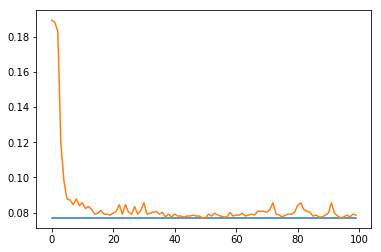

In [16]:

plt.plot(np.arange(0,N_iter,1),np.array(minrloss))
plt.plot(np.arange(0,N_iter,1),np.array(avgrloss))

In [41]:
parent_list[0]
lol=parent_list[0]

In [51]:
np.linalg.norm((lol[:, None] == np.arange(K)).sum(0)-(lol[:, None] == np.arange(K)).sum(0).mean())

43.931765272977593

In [17]:
fusion=[['Valbirse','Malleray','Bévilard','Pontenet'],
        ['Terre di Pedemonte','Cavigliano','Tegna','Verscio'],
        ['Val-de-Charmey','Charmey','Cerniat (FR)'],
        ['Sauge','Frinvillier','Plagne','Vauffelin'],
        ['Buchegg','Aetigkofen','Aetingen','Bibern (SO)','Brügglen','Gossliwil','Hessigkofen','Küttigkofen','Kyburg-Buchegg','Mühledorf (SO)','Tscheppach'],
        ['Domleschg','Almens','Paspels','Pratval','Rodels','Tomils'],
        ['Petit-Val','Châtelat','Monible','Sornetan','Souboz'],
        ['Ilanz/Glion','Castrisch','Ilanz','Ladir','Luven','Pitasch','Riein','Ruschein','Schnaus','Sevgein','Duvin','Pigniu','Rueun','Siat'],
        ['Péry-La Heutte','Péry','La Heutte'],
        ['Calanca','Arvigo','Braggio','Cauco','Selma'],
        ['Bettmeralp','Betten','Martisberg'],
        ['Arzier-Le Muids','Arzier'],
        ['Schinznach','Schinznach-Dorf','Oberflachs'],
        ['Albula/Alvra','Alvaschein','Mon','Stierva','Tiefencastel','Alvaneu','Brienz/Brinzauls','Surava'],
        ['Bussigny','Bussigny-près-Lausanne'],
        ['Stocken-Höfen','Niederstocken','Oberstocken','Höfen'],
        ['Plateau de Diesse','Diesse','Lamboing','Prêles'],
        ['Mendrisio','Besazio','Ligornetto','Meride'],
        ['Lugano','Bogno','Cadro','Carona','Certara','Cimadera','Sonvico','Valcolla'],
        ['Bauma','Sternenberg'],
        ['Scuol','Guarda','Ardez','Tarasp','Ftan','Sent'],
        ['Jegenstorf','Scheunen','Münchringen'],
        ['Fraubrunnen','Büren zum Hof','Etzelkofen','Grafenried','Limpach','Mülchi','Schalunen','Zauggenried'],
        ['Murten','Staatswald Galm'],
        ['Grafschaft','Kommunanz Reckingen-Gluringen/Grafschaft'],
        ['Cadenazzo','Comunanza Cadenazzo/Monteceneri'],
        ['Wiesendangen','Bertschikon'],
        ['Innertkirchen','Gadmen'],
        ['Endingen','Unterendingen'],
        ['Uttigen','Kienersrüti'],
        ['Bremgarten (AG)','Bremgarten','Hermetschwil-Staffeln'],
        ['Zernez','Lavin','Susch'],
        ['Oberdiessbach','Bleiken bei Oberdiessbach'],
        ['Vals','St. Martin']
]


In [18]:
graph_data=pd.read_csv('graph_commune.csv')
graph_data['municipality']
graph_data.columns=['index','neighbors indexes','municipality','neighbors']
fusion2=fusion


graph_data2=graph_data

for elem in fusion:
    graph_data2['municipality'][graph_data['municipality'].isin(elem[1:])]=elem[0]



common=pd.Series(list(set(data.index).intersection(set(graph_data2['municipality']))))
diff1=pd.Series(list(set(data.index)-set(common)))
diff2=pd.Series(list(set(graph_data2['municipality'])-set(common)))
    
graph_data2['municipality'][graph_data['municipality'].isin(diff2)]='lac'


fusion2.append(list(diff2))
fusion2[-1].insert(0,'lac')
print(fusion2)

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


[['Valbirse', 'Malleray', 'Bévilard', 'Pontenet'], ['Terre di Pedemonte', 'Cavigliano', 'Tegna', 'Verscio'], ['Val-de-Charmey', 'Charmey', 'Cerniat (FR)'], ['Sauge', 'Frinvillier', 'Plagne', 'Vauffelin'], ['Buchegg', 'Aetigkofen', 'Aetingen', 'Bibern (SO)', 'Brügglen', 'Gossliwil', 'Hessigkofen', 'Küttigkofen', 'Kyburg-Buchegg', 'Mühledorf (SO)', 'Tscheppach'], ['Domleschg', 'Almens', 'Paspels', 'Pratval', 'Rodels', 'Tomils'], ['Petit-Val', 'Châtelat', 'Monible', 'Sornetan', 'Souboz'], ['Ilanz/Glion', 'Castrisch', 'Ilanz', 'Ladir', 'Luven', 'Pitasch', 'Riein', 'Ruschein', 'Schnaus', 'Sevgein', 'Duvin', 'Pigniu', 'Rueun', 'Siat'], ['Péry-La Heutte', 'Péry', 'La Heutte'], ['Calanca', 'Arvigo', 'Braggio', 'Cauco', 'Selma'], ['Bettmeralp', 'Betten', 'Martisberg'], ['Arzier-Le Muids', 'Arzier'], ['Schinznach', 'Schinznach-Dorf', 'Oberflachs'], ['Albula/Alvra', 'Alvaschein', 'Mon', 'Stierva', 'Tiefencastel', 'Alvaneu', 'Brienz/Brinzauls', 'Surava'], ['Bussigny', 'Bussigny-près-Lausanne'], ['

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
#commune_list=list(graph_data2['municipality'])
adjacency_list=[]

for com in graph_data2['neighbors']:
    j=re.findall('"(.*?)" ',com)
    k=re.findall('\'(.*?)\' ',com)
    #k=[ (x.split('\'', 1)[1] if "\'" in x else x)for x in k ]
    adjacency_list.append(k + j)

#list(set(data.index).union(set(graph_data2['municipality']))

In [58]:
#for commune in graph_data2['municipality']

for elem in fusion:
    for i,nei in enumerate(adjacency_list):
        nei2=pd.Series(nei)
        nei2[nei2.isin(elem[1:])]=elem[0]
        adjacency_list[i]=list(nei2)

KeyboardInterrupt: 

In [64]:
for i,nei in enumerate(adjacency_list):
    adjacency_list[i]=list(set(nei))
    
print(adjacency_list[0])

['Affoltern am Albis', 'Stallikon', 'Hausen am Albis', 'Langnau am Albis', 'Rifferswil', 'Mettmenstetten']


In [105]:
print(adjacency_list)

[['Affoltern am Albis', 'Hausen am Albis', 'Mettmenstetten', 'Stallikon'], ['Aeugst am Albis', 'Hedingen', 'Mettmenstetten', 'Obfelden', 'Stallikon'], ['Hedingen', 'Stallikon', 'Wettswil am Albis', 'Aesch (ZH)'], ['Aeugst am Albis', 'Kappel am Albis', 'Rifferswil', 'Hirzel', 'Langnau am Albis', 'Baar'], ['Affoltern am Albis', 'Bonstetten', 'Stallikon', 'Arni (AG)'], ['Hausen am Albis', 'Knonau', 'Mettmenstetten', 'Rifferswil'], ['Kappel am Albis', 'Maschwanden', 'Mettmenstetten', 'Cham'], ['Knonau', 'Mettmenstetten', 'Obfelden', 'Cham'], ['Aeugst am Albis', 'Affoltern am Albis', 'Kappel am Albis', 'Maschwanden', 'Obfelden'], ['Affoltern am Albis', 'Maschwanden', 'Mettmenstetten', 'Hünenberg'], ['Affoltern am Albis', 'Obfelden', 'Jonen', 'Aristau'], ['Aeugst am Albis', 'Hausen am Albis', 'Kappel am Albis'], ['Aeugst am Albis', 'Affoltern am Albis', 'Bonstetten', 'Wettswil am Albis', 'Adliswil', 'Langnau am Albis', 'Uitikon'], ['Bonstetten', 'Stallikon'], ['Andelfingen', 'Humlikon', 'Oss

In [38]:
commune_list=list(set(graph_data2['municipality']))
commune_list=list(pd.Series(commune_list).sort_values())

adjacency_list_true=([[]]*len(commune_list))

for i,elem in enumerate(commune_list):
    for j,comm in enumerate(graph_data2['municipality']):
        if elem==comm:
            adjacency_list_true[i]=list(set(adjacency_list_true[i]).union(set(adjacency_list[j])))

print(np.sum((pd.Series(commune_list).sort_values())[:-1]!=data.index))

#adjacency_matrix=np.zeros(len(commune_list),len(commune_list))
print(commune_list)

0
['Aadorf', 'Aarau', 'Aarberg', 'Aarburg', 'Aarwangen', 'Abtwil', 'Aclens', 'Acquarossa', 'Adelboden', 'Adligenswil', 'Adlikon', 'Adliswil', 'Aedermannsdorf', 'Aefligen', 'Aegerten', 'Aesch (BL)', 'Aesch (LU)', 'Aesch (ZH)', 'Aeschi (SO)', 'Aeschi bei Spiez', 'Aeugst am Albis', 'Affeltrangen', 'Affoltern am Albis', 'Affoltern im Emmental', 'Agarn', 'Agiez', 'Agno', 'Aigle', 'Aire-la-Ville', 'Airolo', 'Alberswil', 'Albinen', 'Albula/Alvra', 'Alchenstorf', 'Allaman', 'Alle', 'Allmendingen', 'Allschwil', 'Alpnach', 'Alpthal', 'Altbüron', 'Altdorf (UR)', 'Altendorf', 'Alterswil', 'Altikon', 'Altishofen', 'Altnau', 'Alto Malcantone', 'Altstätten', 'Altwis', 'Amden', 'Amlikon-Bissegg', 'Ammerswil', 'Amriswil', 'Amsoldingen', 'Andeer', 'Andelfingen', 'Andermatt', 'Andiast', 'Andwil (SG)', 'Anières', 'Anniviers', 'Anwil', 'Appenzell', 'Apples', 'Aranno', 'Arbaz', 'Arbedo-Castione', 'Arboldswil', 'Arbon', 'Arch', 'Arconciel', 'Ardon', 'Arisdorf', 'Aristau', 'Arlesheim', 'Arnex-sur-Nyon', 'Arne

In [41]:

adjacency_list_index=([[]]*len(commune_list))
for i,elem in enumerate(commune_list):
    for adj_elem in adjacency_list_true[i]:
        print(adj_elem)
        adjacency_list_index[i].append(commune_list.index(adj_elem))


Frauenfeld
Turbenthal
Bichelsee-Balterswil
Hofstetten (ZH)
Elgg
Wängi
Hagenbuch
Matzingen
Küttigen
Suhr
Unterentfelden
Rupperswil
Eppenberg-Wöschnau
Erlinsbach (SO)
Buchs (AG)
Biberstein
Erlinsbach (AG)
Kappelen
Seedorf (BE)
Radelfingen
Bargen (BE)
Lyss
Rothrist
Olten
Oftringen
Starrkirch-Wil
Graben
Bannwil
Langenthal
Wynau
Thunstetten
Roggwil (BE)
Schwarzhäusern
Hohenrain
Sins
Echichens
Bussigny
Gollion
Romanel-sur-Morges
Vufflens-la-Ville
Vullierens
Bremblens
Faido
Sobrio
Blenio
Serravalle
Lenk
Frutigen
St. Stephan
Leukerbad
Diemtigen
Kandersteg
Dierikon
Udligenswil
Meggen
Ebikon
Küssnacht (SZ)
Luzern
Thalheim an der Thur
Dägerlen
Humlikon
Ossingen
Andelfingen
Rüschlikon
Stallikon
Zürich
Kilchberg (ZH)
Langnau am Albis
Schelten
Rumisberg
Herbetswil
Matzendorf
Seehof
Mümliswil-Ramiswil
Beinwil (SO)
Rüdtligen-Alchenflüh
Fraubrunnen
Bätterkinden
Utzenstorf
Schwadernau
Studen (BE)
Brügg
Jens
Port
Dornach
Pfeffingen
Ettingen
Duggingen
Therwil
Reinach (BL)
Altwis
Beinwil am See
Schongau
Fa

ValueError: 'Abergement" ' is not in list